## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Clear the data 

After running this part of the code, we can work with the data from file: ```WISDM_ar_v1.1_raw_cleared.txt```.

In [3]:
f_read = open("../data/WISDM/WISDM_ar_v1.1_raw.txt", "r")
f_write = open("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", "w")
for string in f_read.readlines():
    if string[-1] == '\n':
        string = string[:-1]
    if len(string) > 0:
        string_list = string.split(';')
        if len(string_list) > 2:
            for row in string_list[:2]:
                words = row.split(',')
                if len(words) > 5:
                    if len(words[5]) > 0:
                        f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                               words[2], words[3], 
                                                               words[4], words[5]))
        else:
            words = string_list[0].split(',')
            if len(words) > 5:
                if len(words[5]) > 0:
                    f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                           words[2], words[3], 
                                                           words[4], words[5]))
f_read.close()
f_write.close()

## Read data

Read the data to pandas:  
* ```id_user``` - identification number of the user (from 1 to 36 inclusively);
* ```activity``` - type of activity (our classes: ```['Downstairs', 'Sitting', 'Walking', 'Upstairs', 'Jogging', 'Standing']```);
* ```timestamp``` - time of measurement (in nanoseconds);
* ```x``` - acceleration in $x$ direction;
* ```y``` - acceleration in $y$ direction;
* ```z``` - acceleration in $z$ direction;

In [4]:
data = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", delimiter=',', header=None)
data.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']
data.head()

,id_user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Class distribution:

In [5]:
classes = list(set(data['activity']))
for activity in classes:
    nb = np.sum(data['activity'] == activity)
    print("{:<15}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / data.shape[0]))
print()
print("Number of objects: {:d}".format(data.shape[0]))

Standing       48395    4.41  %
Walking        424399   38.64 %
Upstairs       122869   11.19 %
Sitting        59939    5.46  %
Jogging        342179   31.16 %
Downstairs     100427   9.14  %
()
Number of objects: 1098208


Example of the data:

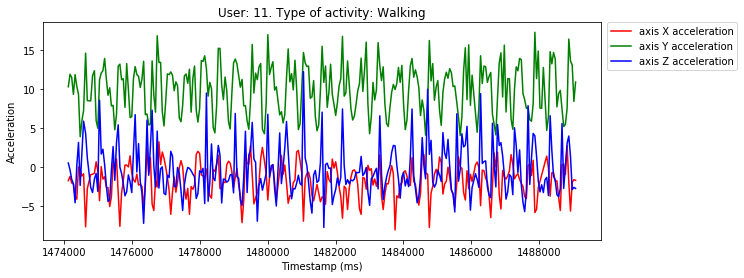

In [6]:
id_user, activity = 11, 'Walking'

mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
x = np.array(data.loc[mask, 'timestamp'])[:np.min([300, np.sum(mask)])] / 10**6
yx = np.array(data.loc[mask, 'x'])[:np.min([300, np.sum(mask)])]
yy = np.array(data.loc[mask, 'y'])[:np.min([300, np.sum(mask)])]
yz = np.array(data.loc[mask, 'z'])[:np.min([300, np.sum(mask)])]

if np.sum(mask) > 0:
    plt.figure(figsize=(10, 4))
    plt.plot(x, yx, 'r', label='axis X acceleration')
    plt.plot(x, yy, 'g', label='axis Y acceleration')
    plt.plot(x, yz, 'b', label='axis Z acceleration')
    plt.xlabel('Timestamp (ms)')
    plt.ylabel('Acceleration')
    plt.title("User: {}. Type of activity: {}".format(id_user, activity))
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.show()
else:
    print("There is no such data.")

## Creating object-feature matrix

So we need to construct 10 seconds time series. To do it we need to remember the following:
* each time series should be from one user and one type of activity;
* in the time series timestamp should't differ more then 0.2 second (empirical rule, in ideal all timestamp should differ on 50 ms = 0.05 second).

Now let's create **object-feature** matrix:

In [7]:
def check_candidate(candidate, threshold=2.*1e8):
    tsp = np.array(candidate['timestamp'])
    diffs = tsp[1:] - tsp[:-1]
    
    return np.sum(diffs > threshold) == 0

def get_time_series(accelerations, nb=200):
    accelerations.index = [i for i in range(len(accelerations))]
    TS = []
    st = 0
    fi = st + nb
    while fi < len(accelerations):
        candidate = accelerations.loc[[st + i for i in range(nb)], :]
        if check_candidate(candidate):
            TS.append([np.array(candidate['x']), 
                       np.array(candidate['y']), 
                       np.array(candidate['z'])])
        st = fi
        fi += nb
    
    return TS

## Feature extraction

### Expert functions

The idea is the following: we will consider 10 seconds time series (or 200 points of measurements) and calculate 40 features:
* ```[3]``` - mean acceleration of each axis;
* ```[3]``` - std of acceleration of each axis;
* ```[3]``` - mean absolute deviation of acceleration of each axis;
* ```[1]``` - mean acceleration;
* ```[30]``` - distribution of time series values of each axis. First of all we calculate min and max of each component ($X, Y, Z$) from the whole interval. Then we divide the range of values of each component into 10 equal intervals and calculate on each each interval the percent of values that are in it (in the corresponding interval).  

And apply LogisticRegression and SVM.

In [8]:
def get_expert_features(ts):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    n = x.shape[0]
    features = []
    features.append(x.mean())
    features.append(y.mean())
    features.append(z.mean())
    features.append(x.std())
    features.append(y.std())
    features.append(z.std())
    features.append(np.abs(x - x.mean()).mean())
    features.append(np.abs(y - y.mean()).mean())
    features.append(np.abs(z - z.mean()).mean())
    features.append((x+y+z).mean() / 3.)
    x_range = np.linspace(x.min(), x.max(), 11)
    y_range = np.linspace(y.min(), y.max(), 11)
    z_range = np.linspace(z.min(), z.max(), 11)
    for i in range(10):
        features.append(1. * np.sum((x_range[i] <= x) & (x < x_range[i+1])) / n)
        features.append(1. * np.sum((y_range[i] <= y) & (y < y_range[i+1])) / n)
        features.append(1. * np.sum((z_range[i] <= z) & (z < z_range[i+1])) / n)
    
    return features

def get_expert_matrix(data, classes):

    columns = ['avg_x', 'avg_y', 'avg_z', 
               'std_x', 'std_y', 'std_z', 
               'abs_x', 'abs_y', 'abs_z', 'mean']
    for i in range(10):
        name = str(i) + '_'
        columns += [name + 'x', name + 'y', name + 'z']
    df = pd.DataFrame(columns=['activity']+columns) 

    id_range = np.unique(np.array(data['id_user']))
    for id_user in id_range:
        for activity in classes:
            mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
            accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
            TS = get_time_series(accelerations, nb=200)
            for ts in TS:
                features = get_expert_features(ts)
                df.loc[len(df), :] = [classes.index(activity)] + features
    return df

### Autoregression model

In [9]:
def get_autoregressive_features(ts, n=10):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    m = x.shape[0]
    features = []
    X = np.zeros([m-n, n])
    Y = np.zeros(m-n)
    for axis in [x, y, z]:
        for i in range(m-n):
            X[i, :] = axis[i:i+n]
            Y[i] = axis[i+n]
        lr = LinearRegression()
        lr.fit(X, Y)
        features.append(lr.intercept_)
        features.extend(lr.coef_)
    
    return features

def get_autoregressive_matrix(data, classes, n_features=10):
    
    columns = []
    for ax in ['x', 'y', 'z']:
        columns += ['intercept_' + ax]
        for i in range(n_features):
            columns += ['coef_' + str(i) + '_' + ax]
        df = pd.DataFrame(columns=['activity']+columns)

    id_range = np.unique(np.array(data['id_user']))
    for id_user in id_range:
        for activity in classes:
            mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
            accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
            TS = get_time_series(accelerations, nb=200)
            for ts in TS:
                features = get_autoregressive_features(ts, n=n_features)
                df.loc[len(df), :] = [classes.index(activity)] + features
    return df

### Spectrum analysis

In [10]:
def get_spectrum_features(ts, n=10):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    m = x.shape[0]
    features = []
    X = np.zeros([m-n, n])
    Y = np.zeros(m-n)
    for axis in [x, y, z]:
        for i in range(m-n):
            X[i, :] = axis[i:i+n]
        h = sc.linalg.svd(X.T.dot(X), compute_uv=False, overwrite_a=True)
        features.extend(h)
    
    return features

def get_spectrum_matrix(data, classes, n_features=10):
    
    columns = []
    for ax in ['x', 'y', 'z']:
        for i in range(n_features):
            columns += ['eigv_' + str(i) + '_' + ax]
        df = pd.DataFrame(columns=['activity']+columns)

    id_range = np.unique(np.array(data['id_user']))
    for id_user in id_range:
        for activity in classes:
            mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
            accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
            TS = get_time_series(accelerations, nb=200)
            for ts in TS:
                features = get_spectrum_features(ts, n=n_features)
                df.loc[len(df), :] = [classes.index(activity)] + features
    return df

## В другое место 

Class distribution:

In [14]:
for activity in classes:
    nb = np.sum(df['activity'] == classes.index(activity))
    print("{:<15}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / df.shape[0]))
print()
print("Number of objects: {:d}".format(df.shape[0]))

Standing       229      5.30  %
Walking        1917     44.36 %
Upstairs       466      10.78 %
Sitting        277      6.41  %
Jogging        1075     24.88 %
Downstairs     357      8.26  %
()
Number of objects: 4321


## Classification

In [15]:
def get_internal_score(clf, X, y, max_iter=20):
    nb = np.unique(y).shape[0]
    scores = np.zeros(nb+1)
    for j in range(max_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        scores[0] += accuracy_score(y_test, y_predict)
        for i in range(nb):
            scores[i+1] += accuracy_score(1*(np.array(y_test) == i), 
                                         1*(np.array(y_predict) == i))
            
    return scores / max_iter

In [16]:
def get_score(df, estimator, params_grid, test_size=0.3):
    X = df.iloc[:, 1:].values
    y = df['activity'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    clf = GridSearchCV(estimator, params_grid)
    clf.fit(X_train, list(y_train))
    clf_lr = clf.best_estimator_
    scores = get_internal_score(clf_lr, X, list(y))
    return scores

### Expert functions, logistic regresison

In [18]:
df = get_expert_matrix(data, classes)

scores['lr_expert'] = get_score(df, LogisticRegression(), params)

### Autogression model, logistic regresison

In [17]:
params = {'penalty': ['l1', 'l2'], 
              'class_weight': ['balanced', None], 
              'C': 10. ** np.arange(0, 5, 1)}

scores = {}

for n in [10, 20, 30, 40]:
    df = get_autoregressive_matrix(data, classes, n_features=n)

    scores['lr_ar_' + str(n)] = get_score(df, LogisticRegression(), params)

### Spectrum analysis, logistic regresison

In [19]:
for n in [10, 20, 30, 40]:
    df = get_spectrum_matrix(data, classes, n_features=n)

    scores['lr_spectrum_' + str(n)] = get_score(df, LogisticRegression(), params)

In [20]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.columns = ['all'] + classes

scores_df

,all,Standing,Walking,Upstairs,Sitting,Jogging,Downstairs
lr_ar_30,0.908982,0.983231,0.965767,0.946955,0.978258,0.988126,0.955628
lr_expert,0.854318,0.990478,0.895451,0.908905,0.989244,0.983423,0.941133
lr_ar_20,0.906823,0.984310,0.957170,0.945644,0.982652,0.987086,0.956785
lr_ar_10,0.875675,0.982151,0.936777,0.939784,0.982460,0.973824,0.936353
lr_ar_40,0.894988,0.978643,0.960871,0.942406,0.975713,0.984310,0.948034
lr_spectrum_30,0.880609,0.996608,0.939052,0.913570,0.996415,0.983847,0.931727
lr_spectrum_20,0.841210,0.996376,0.864958,0.901311,0.995258,0.985968,0.938551
lr_spectrum_10,0.834850,0.996800,0.876099,0.891480,0.995952,0.985505,0.923863
lr_spectrum_40,0.890401,0.996839,0.948574,0.917078,0.996453,0.984310,0.937548
